Group Project
Students will work together in groups to complete a Data Science project from the beginning (downloading data from the web) to the end (communicating their methods and conclusions in an electronic report). The electronic report will be a Jupyter notebook in which the code cells will download a dataset (chosen from the list of options below) from the web, reproducibly and sensibly wrangle and clean, summarize and visualize the data, as well as appropriately answer a predictive question. Markdown cells will be used throughout the document to narrate the analysis to communicates the question asked, methods used and the conclusion reached.


For this project, you will need to formulate and answer a predictive question about a dataset of your choice using either classification or regression. Below we list some suggested data sets, however, we encourage bring your own dataset from elsewhere (e.g. Wikipedia, Kaggle, etc) as long as you get the dataset approved by your group's TA. Note that you are not allowed to pick a dataset that we have already used during lecture or in one of the assignments.change



Title

Introduction

Methods and Results

In [41]:
install.packages("tidyverse")
library(ggplot2)
library(tidyverse)
library(tidymodels)
install.packages("kknn")
options(repr.matrix.max.rows = 10)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [42]:
#reading in data which is already tidy as given, and splitting it into training and testing sets
pimadata <- tibble(read_csv("https://raw.githubusercontent.com/DHu06/dsci100-project/main/diabetes.csv"))
            pimadata_split <- pimadata|> mutate(Outcome = as.factor(Outcome)) |>
                    select(Glucose, BloodPressure, SkinThickness, Insulin, BMI, Age, Outcome) |>
                    initial_split(prop = 0.75, strata = Outcome)
            pimadata_training <- training(pimadata_split)
            pimadata_testing <- testing(pimadata_split)
pimadata_training

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
89,66,23,94,28.1,21,0
116,74,0,0,25.6,30,0
115,0,0,0,35.3,29,0
139,80,0,0,27.1,57,0
103,30,38,83,43.3,33,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
128,88,39,110,36.5,37,1
123,72,0,0,36.3,52,1
190,92,0,0,35.5,66,1


In [43]:
set.seed(1234) 
#Create a K-nearest neighbor model to find the best k
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#Create a recipe that uses all predictors and a model specification with tuning on the number of neighbours
diabete_recipe <- recipe(Outcome ~., data = pimadata_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

#Perform a 5-fold cross-validation on the training set
vfold <- vfold_cv(pimadata_training, v = 5, strata = Outcome)

#Create a workflow analysis with your recipe and model specification using k from 1 to 100 by 5
#Collect the metrics from the workflow analysis
knn_results <- workflow() |>
                 add_recipe(diabete_recipe) |>
                 add_model(knn_tune) |>
                 tune_grid(resamples = vfold, grid = tibble(neighbors = seq(from = 1, to = 100, by = 5))) |>
                 collect_metrics()

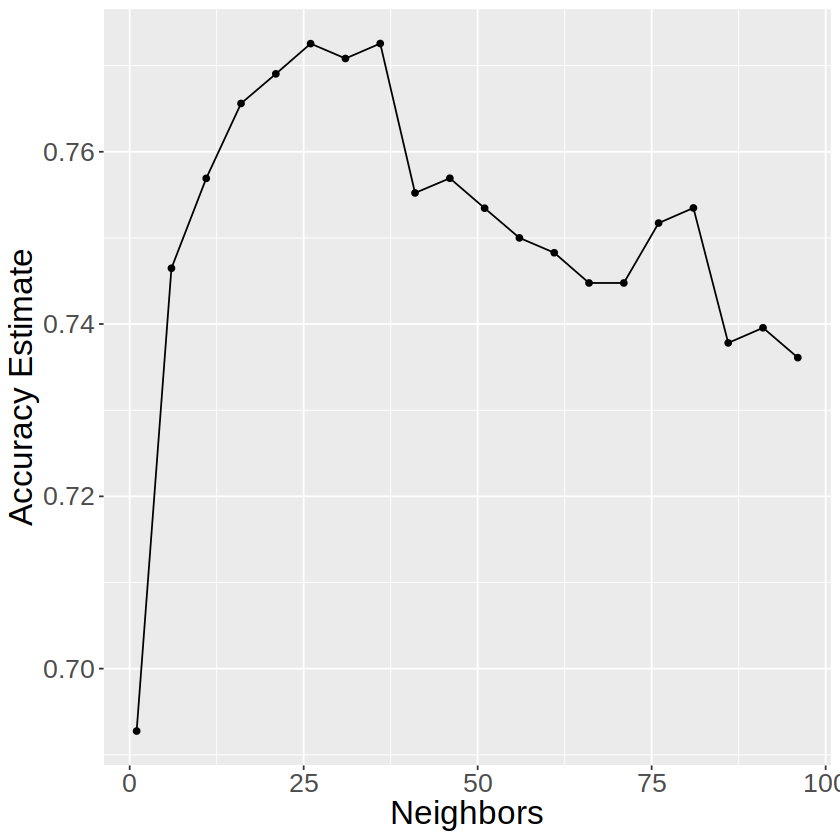

In [44]:
#Visualize the value of k vs the accuracy of the model
accuracies <- knn_results |>
                 filter(.metric == "accuracy") |>
                 mutate(mean = as.numeric(mean), neighbors = as.numeric(neighbors))
cross_val_plot <- accuracies |>
                  ggplot(aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Neighbors", y = "Accuracy Estimate") +
                  theme(text = element_text(size = 20))     
cross_val_plot

[1] 0.7395833

          Truth
Prediction   0   1
         0 109  34
         1  16  33

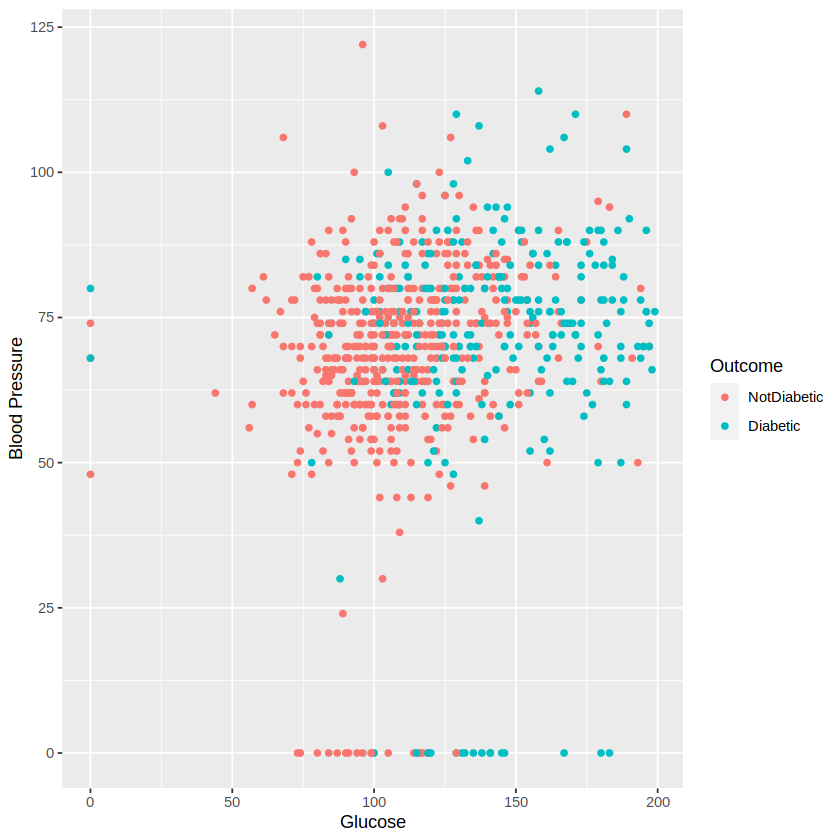

In [58]:
#Using best K creating a K-nearest model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) |>
  set_engine("kknn") |>
  set_mode("classification")

#Recreating a workflow with best K
knn_fit <- workflow() |>
  add_recipe(diabete_recipe) |>
  add_model(knn_spec) |>
  fit(data = pimadata_training)

#Make predictions on testing set using best K
diabetes_predictions <- predict(knn_fit, pimadata_testing) |>
  bind_cols(pimadata_testing)

accuracy<-diabetes_predictions |>
  metrics(truth = Outcome, estimate = .pred_class) |>
  filter(.metric == "accuracy")|>
select(.estimate) |>
  pull()
accuracy
#Confusion Matrix
confusion <- diabetes_predictions |>
             conf_mat(truth = Outcome, estimate = .pred_class)
confusion
#Precision and Recall calculated from confusion matrix (not sure on how to pull directly from the matrix without using a different library)


Blood_vs_Glucose_plot<-pimadata|> mutate(Outcome = as.factor(Outcome))|>mutate(Outcome = fct_recode(Outcome, "Diabetic" = "1", "NotDiabetic" = "0"))|>ggplot(aes(x = Glucose, y = BloodPressure, color=Outcome)) +
                  geom_point() +
                  labs(x = "Glucose", y = "Blood Pressure",Colour="blue")


Blood_vs_Glucose_plot